In [1]:
import pandas as pd
import numpy as np
import re 
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV

contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [2]:
def clean_text(text, remove_stopwords = True):
    '''Text Preprocessing'''

    # Convert words to lower case
    text = text.lower()

    # Expand contractions
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\b\w{1,3}\b', '', text)
    text = text.replace("data warehouse", "datawarehouse")
    text = text.replace("data warehouses", "datawarehouse")
    text = text.replace("database warehouse", "datawarehouse")
    text = text.replace("database warehousing", "datawarehouse")
    
    
    # remove stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    #Lemmatize each token
    list = nltk.word_tokenize(text)
    wnl = WordNetLemmatizer()
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list])
    
    return text 

In [3]:
def normalize_sparse(csr_matrix):
    nonzero_rows = csr_matrix.nonzero()[0]
    for idx in np.unique(nonzero_rows):
        data_idx = np.where(nonzero_rows==idx)[0]
        abs_max = np.max(np.abs(csr_matrix.data[data_idx]))
        if abs_max != 0:
            csr_matrix.data[data_idx] = 1./abs_max * csr_matrix.data[data_idx]
    return csr_matrix

In [4]:
#Model and data test
df = pd.read_excel(r'Information for model training.xlsx')
model_data = df["Data"].tolist()
for x in range(len(model_data)):
    model_data[x] = clean_text(model_data[x])

#Data transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(model_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = df["Type"].tolist()

#Model
clf = LogisticRegression(C = 0.2, random_state=0).fit(X_train_tfidf, y_train)


In [5]:
#Test results
#Upload test data
train_df = pd.read_excel(r'Database iteration 2.xlsx')
train_df["data"] = train_df["Abstract"]
train_df.dropna(subset = ["data"], inplace=True)
X_unknown_beta = train_df["data"].tolist()
for x in range(len(X_unknown_beta)):
    X_unknown_beta[x] = clean_text(X_unknown_beta[x])


#Test model
X_test_counts = count_vect.transform(X_unknown_beta)


#Probability
predicted = clf.predict_proba(X_test_counts)
predicted_cat = clf.predict(X_test_counts)
df_predictions = pd.DataFrame(predicted, index=train_df.index)
series1 = pd.Series(df_predictions[1].values, index=df_predictions.index)
series2 = pd.Series(train_df['Source'].values, index=train_df.index)
final_df = pd.concat({'Prob': series1, 'Title': series2},axis=1)
final_df['Prob'] = final_df[final_df['Prob'] > 0.9]['Prob']
final_df.dropna()


,Prob,Title
1,0.942249,Research on Optimization of Multi-AGV Path Bas...
23,0.998621,Qrobot: A quantum computing approach in mobile...
29,0.995168,Ant colony optimization with warm-up Neroni M....
34,0.958257,A Dynamic Route-Planning System Based on Indus...
37,0.985399,12th International Conference on Computational...
...,...,...
566,0.986104,Analysis and Optimization of the Robotic Mobil...
584,0.959771,Route planning of stacker by improved genetic ...
588,0.940498,Application of Machine Learning Methods for Pa...
592,0.937032,An Autonomous Food Wastage Control Warehouse: ...


In [6]:


df = pd.read_excel(r'Information for model training.xlsx')
df = df.replace(r'^\s*$', np.nan, regex=True)
model_data = df["Source"]+df["Data"].tolist()
for x in range(len(model_data)):
    model_data[x] = clean_text(model_data[x])
#Data transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(model_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf = normalize_sparse(X_train_tfidf)
y_train = df["Type"].tolist()


param_grid = {'C': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1, 
                    1.25, 1.5, 1.75, 10, 100, 1000], 'penalty': ['l1', 'l2']}

#macro weighs each class equally whereas micro weights each sample equally
scoring = ['roc_auc', 'f1_macro']
                         
clf = GridSearchCV(LogisticRegression(solver = 'liblinear'), param_grid,
                           scoring = scoring,
                           cv = 10,
                           verbose=0,
                           refit='f1_macro')

clf = clf.fit(X_train_tfidf, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",clf.best_estimator_)
print("\n Best score:\n",clf.best_score_)
print("\n The best parameters across ALL searched params:\n",clf.best_params_)
df = pd.DataFrame.from_dict(clf.cv_results_)

final_df = df.filter(["param_C", "param_penalty", "mean_test_roc_auc", "mean_test_f1_macro"])

print(final_df)

penalty = clf.best_params_.get('penalty')
c_value = clf.best_params_.get('C')


 Results from Grid Search 

 The best estimator across ALL searched params:
 LogisticRegression(C=1000, penalty='l1', solver='liblinear')

 Best score:
 0.7594158775794261

 The best parameters across ALL searched params:
 {'C': 1000, 'penalty': 'l1'}
   param_C param_penalty  mean_test_roc_auc  mean_test_f1_macro
0    0.001            l1           0.500000            0.457335
1    0.001            l2           0.756523            0.457335
2     0.01            l1           0.500000            0.457335
3     0.01            l2           0.837069            0.457335
4      0.1            l1           0.500000            0.457335
5      0.1            l2           0.948785            0.457335
6     0.25            l1           0.887815            0.492352
7     0.25            l2           0.957108            0.527369
8      0.5            l1           0.930277            0.619303
9      0.5            l2           0.960669            0.648880
10    0.75            l1           0.928477 

In [7]:
X_train_tfidf

<299x7778 sparse matrix of type '<class 'numpy.float64'>'
	with 34246 stored elements in Compressed Sparse Row format>

In [8]:
#Test probability on Training Data
#Upload data
df = pd.read_excel(r'Information for model training.xlsx')
model_data = df["Source"]+df["Data"].tolist()
for x in range(len(model_data)):
    model_data[x] = clean_text(model_data[x])

#Data transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(model_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf = normalize_sparse(X_train_tfidf)
y_train = df["Type"].tolist()

#Model
clf = LogisticRegression(solver = 'liblinear', penalty = penalty, C = c_value).fit(X_train_tfidf, y_train)

#Upload test data
train_df = pd.read_excel(r'Information for model training.xlsx')
train_df["data"] = train_df["Source"]+". "+train_df["Data"]
train_df.dropna(subset = ["data"], inplace=True)
X_unknown_beta = train_df["data"].tolist()
for x in range(len(X_unknown_beta)):
    X_unknown_beta[x] = clean_text(X_unknown_beta[x])
X_test_counts = count_vect.transform(X_unknown_beta)
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf = normalize_sparse(X_test_tfidf)


#Probability
category = clf.predict(X_test_tfidf)
predicted = clf.predict_proba(X_test_tfidf)
df_predictions = pd.DataFrame(predicted, index=train_df.index)
df_category = pd.DataFrame(category, index=train_df.index)
series1 = pd.Series(df_predictions[1].values, index=train_df.index)
series2 = pd.Series(train_df['Source'].values, index=train_df.index)
series3 = pd.Series(train_df['Data'].values, index=train_df.index)
series4 = pd.Series(df_category[0].values, index=train_df.index)
series5 = pd.Series(train_df['Type'].values, index=train_df.index)
final_df = pd.concat({'Real Category': series5, 'Predicted Category': series4, 'Prob': series1, 'Title': series2, 'Abstract': series3},axis=1)
#final_df['Prob'] = final_df[final_df['Prob'] > 0.9]['Prob']
#final_df.dropna()

file_name = 'Training Data Results.xlsx'
final_df.to_excel(file_name)

In [9]:

#Upload data
df = pd.read_excel(r'Information for model training.xlsx')
model_data = df["Source"]+df["Data"].tolist()
for x in range(len(model_data)):
    model_data[x] = clean_text(model_data[x])

#Data transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(model_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf = normalize_sparse(X_train_tfidf)
y_train = df["Type"].tolist()

#Model
clf = LogisticRegression(solver = 'liblinear', penalty = penalty, C = c_value).fit(X_train_tfidf, y_train)

#Upload test data
train_df = pd.read_excel(r'Database iteration 3.xlsx')
train_df["data"] = train_df["Source"]+". "+train_df["Abstract"]
train_df.dropna(subset = ["data"], inplace=True)
X_unknown_beta = train_df["data"].tolist()
for x in range(len(X_unknown_beta)):
    X_unknown_beta[x] = clean_text(X_unknown_beta[x])
X_test_counts = count_vect.transform(X_unknown_beta)
tfidf_transformer = TfidfTransformer()
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)
X_test_tfidf = normalize_sparse(X_test_tfidf)

#Probability
category = clf.predict(X_test_tfidf)
predicted = clf.predict_proba(X_test_tfidf)
df_predictions = pd.DataFrame(predicted, index=train_df.index)
df_category = pd.DataFrame(category, index=train_df.index)
series1 = pd.Series(df_predictions[1].values, index=train_df.index)
series2 = pd.Series(train_df['Source'].values, index=train_df.index)
series3 = pd.Series(train_df['Abstract'].values, index=train_df.index)
series4 = pd.Series(df_category[0].values, index=train_df.index)
final_df = pd.concat({'Category': series4, 'Prob': series1, 'Title': series2, 'Abstract': series3},axis=1)
#final_df['Prob'] = final_df[final_df['Prob'] > 0.9]['Prob']
#final_df.dropna()

file_name = 'Results.xlsx'
final_df.to_excel(file_name)



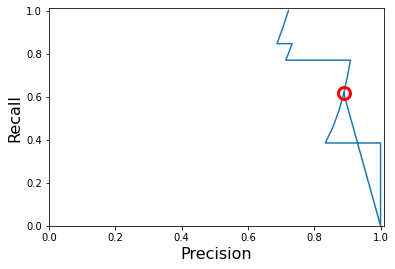

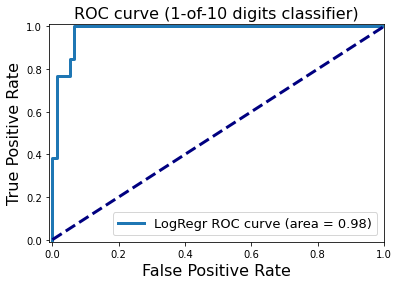

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
from sklearn import preprocessing
import matplotlib.pyplot as plt

#Upload data
df = pd.read_excel(r'Information for model training.xlsx')
model_data = df["Data"].tolist()
for x in range(len(model_data)):
    model_data[x] = clean_text(model_data[x])

#Data transformation
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(model_data)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
y_train = df["Type"].tolist()

#Split data
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y_train, test_size=0.30)

#Model
clf = LogisticRegression(solver = 'liblinear', penalty = penalty, C = c_value).fit(X_train, y_train)

y_scores = clf.fit(X_train, y_train).decision_function(X_test)     
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)      
closest_zero = np.argmin(np.abs(thresholds))
closest_zero_p = precision[closest_zero]
closest_zero_r = recall[closest_zero]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores)
roc_auc_lr = auc(fpr_lr, tpr_lr)
recall = np.append(recall, closest_zero_r)
precision = np.append(precision, closest_zero_p)

#Precision-Recall Curve
plt.figure()
plt.xlim([0.0, 1.01])
plt.ylim([0.0, 1.01])
plt.plot(precision, recall, label='Precision-Recall Curve')
plt.plot(closest_zero_p, closest_zero_r, 'o', markersize = 12, fillstyle = 'none', c='r', mew=3)
plt.xlabel('Precision', fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.show()

#ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_scores)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure()
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='LogRegr ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

In [11]:
conda list


# packages in environment at C:\Users\guaso\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0            py39haa95532_0  
alabaster                 0.7.12             pyhd3eb1b0_0  
anaconda                  2021.11                  py39_0  
anaconda-client           1.9.0            py39haa95532_0  
anaconda-navigator        2.1.2            py39haa95532_0  
anaconda-project          0.10.1             pyhd3eb1b0_0  
anyio                     2.2.0            py39haa95532_2  
appdirs                   1.4.4              pyhd3eb1b0_0  
argh                      0.26.2           py39haa95532_0  
argon2-cffi               20.1.0           py39h2bbff1b_1  
arrow                     0.13.1           py39haa95532_0  
asn1crypto                1.4.0                      py_0  
astroid                   2.6.6            py39haa95532_0  
astropy                   4.3.1            py39hc7d831d_0  
async_generator           1.10      

nbclient                  0.5.3              pyhd3eb1b0_0  
nbconvert                 6.1.0            py39haa95532_0  
nbformat                  5.1.3              pyhd3eb1b0_0  
nest-asyncio              1.5.1              pyhd3eb1b0_0  
networkx                  2.6.3              pyhd3eb1b0_0  
nltk                      3.6.5              pyhd3eb1b0_0  
nose                      1.3.7           pyhd3eb1b0_1006  
notebook                  6.4.5            py39haa95532_0  
numba                     0.54.1           py39hf11a4ad_0  
numexpr                   2.7.3            py39hb80d3ca_1  
numpy                     1.20.3           py39ha4e8547_0  
numpy-base                1.20.3           py39hc2deb75_0  
numpydoc                  1.1.0              pyhd3eb1b0_1  
olefile                   0.46               pyhd3eb1b0_0  
openjpeg                  2.4.0                h4fc8c34_0  
openpyxl                  3.0.9              pyhd3eb1b0_0  
openssl                   1.1.1l        